# 1. Загрузка библиотек и базовые настройки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor

# 2. Задание функции для валидации модели

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# 3. Загрузка датасетов

In [3]:
train_df = pd.read_csv('./train.csv', sep=',')
test_df = pd.read_csv('./test.csv', sep=',')

# 4. Создание класса для обработки данных

In [4]:
class Data:
    
    def __init__(self):
        self.df_mean_price_dist = None
        self.medians = None
        self.mode_Rooms = None
        self.mode_HouseFloor = None
        self.mode_Floor = None
        self.mode_Social_1 = None
        self.mode_Healthcare_2 = None
        self.mode_Shops_1 = None
        
    # уменьшение занимаемой памяти
    def reduce_mem_usage(self, df):
    
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        return df

    # Изменение формата столбцов и названий   
    def new_fiew(self, df):
        df = df.astype({'HouseFloor': np.int8, 
                        'Rooms': np.int8, 
                        'Social_2': np.float32, 
                        'Social_3': np.float32
                       })
        df.rename(columns = {'DistrictId' : 'District', 
                             'HouseYear' : 'Year', 
                             'Helthcare_2' : 'Healthcare_2'}, 
                  inplace = True)
        return df
    
    # Расчет медиан и мод на тренировочном датасете
    def fit(self, df):
        self.medians = df.median()
        self.mode_Rooms = df['Rooms'].mode()[0]
        self.mode_HouseFloor = df['HouseFloor'].mode()[0]
        self.mode_Floor = df['Floor'].mode()[0]
        
        df['Price_per_square'] = df['Price'] / df['Square'].round(decimals=3)
        self.df_mean_price_dist = df.groupby('District').median()['Price_per_square'].round()
        df.drop(['Price_per_square'], inplace=True, axis=1)
        return df
              
    # Обработка выбросов
    def transform(self, df):
        df.loc[(df['Rooms'] > 6) | (df['Rooms'] < 1), 'Rooms'] = self.mode_Rooms
        df.loc[(df['Square'] > 300) | (df['Square'] < 15), 'Square'] = self.medians.Square
        df.loc[(df['KitchenSquare'] > 30) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = self.medians.KitchenSquare
        df.loc[(df['LifeSquare'] > 280) | (df['LifeSquare'] < 10), 'LifeSquare'] = self.medians.LifeSquare
        df.loc[(df['HouseFloor'] > 50) | (df['HouseFloor'] < 1), 'HouseFloor'] = self.mode_HouseFloor
        df.loc[(df['Floor'] > 50) | (df['Floor'] < 1), 'Floor'] = self.mode_Floor
        df.loc[df['Year'] > 2020, 'Year'] = 2020
        return df
    
    # Генерация новых признаков и обработка пропусков
    def new_features(self, df):
        df['Floor_altitude'] = (df['Floor'] / df['HouseFloor']).round(decimals=1)
        df.loc[df['Floor_altitude'] > 1, 'Floor_altitude'] = df['Floor_altitude'].median()
        df['IsFirstFloor'] = (df['Floor_altitude'] < 0.2).astype(int)
        
        df['LifeSquare_fraction'] = (1 - df['KitchenSquare'] / df['Square'])
        df.loc[df['LifeSquare_fraction'] < 0.7, 'LifeSquare_fraction'] = df['LifeSquare_fraction'].median()
        df['LifeSquare_new'] = df['LifeSquare_fraction'] * df['Square'].round(decimals=1)
        df.loc[df['LifeSquare'] == df['LifeSquare'].median(), 'LifeSquare'] = df['LifeSquare_new']
        df.loc[(df['LifeSquare'].isna()), 'LifeSquare'] = df['LifeSquare_new']
        df.loc[(df['LifeSquare'].isna()), 'LifeSquare'] = df['LifeSquare'].median()
        
        df_mean = pd.DataFrame(self.df_mean_price_dist)
        df_mean.rename(columns = {'Price_per_square' : 'Median_Price_per_square'}, inplace = True)
        df = df.merge(df_mean, on=['District'], how='left')
        df.loc[(df['Median_Price_per_square'].isna()), 'Median_Price_per_square'] = df['Median_Price_per_square'].median()
        
        df['Year_expensive'] = 0
        df.loc[df['Year'] <= 1955, 'Year_expensive'] = 10
        df.loc[(df['Year'] > 1995) & (df['Year'] <= 2005), 'Year_expensive'] = 9
        df.loc[(df['Year'] > 1985) & (df['Year'] <= 1995), 'Year_expensive'] = 8
        df.loc[(df['Year'] > 1977) & (df['Year'] <= 1985), 'Year_expensive'] = 7
        df.loc[df['Year'] == 1976, 'Year_expensive'] = 7
        df.loc[(df['Year'] > 1955) & (df['Year'] <= 1965), 'Year_expensive'] = 6
        df.loc[(df['Year'] > 2005) & (df['Year'] <= 2015), 'Year_expensive'] = 5
        df.loc[(df['Year'] > 1970) & (df['Year'] <= 1975), 'Year_expensive'] = 4
        df.loc[df['Year'] > 2015, 'Year_expensive'] = 3
        df.loc[(df['Year'] > 1965) & (df['Year'] <= 1970), 'Year_expensive'] = 2
        df.loc[df['Year'] == 1977, 'Year_expensive'] = 1
        
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

        df.drop(['Healthcare_1', 'Year', 'LifeSquare_new', 'LifeSquare_fraction'], 
                inplace=True, axis=1)
        return df

In [5]:
preprocessor = Data()

# 5. Уменьшение занимаемой памяти и переименование столбцов

_Привожу датасеты к формату, который мне нравится - чтобы использовался действительно максимальный необходимый формат для передачи значений признака. Названия стоблцов тоже поменял под себя - так мне удобнее воспринимать._

In [6]:
train_df = preprocessor.reduce_mem_usage(train_df)
test_df = preprocessor.reduce_mem_usage(test_df)

train_df = preprocessor.new_fiew(train_df)
test_df = preprocessor.new_fiew(test_df)

# 6. EDA тренировочного датасета

## а. Общий вид

_Выводим информацию о том, сколько строк и столбцов в тренировочном  и тестовом датасетах._

In [7]:
train_df.shape

(10000, 20)

In [8]:
test_df.shape

(5000, 19)

_Выводим общую информацию о признаках в треинровочном датасете._

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   District       10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   Year           10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  float32 
 14  Social_3       10000 non-null  float32 
 15  Healthcare_1   5202 non-null   float32 
 16  Healthcare_2   10000 non-null  int8    
 17  Shops_1        10000 non-null  i

## b. Анализ количественных переменных

_Выводим статистики количественных переменных. Анализируем из. Видим, что существую явные анамалии, например, min 0 в признаках  Rooms и KitchenSquare, max 7480 в LifeSquare, необычный числовой формат для года, отклонения средних от мод и т.п._

In [10]:
train_df.describe()

Id      District         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315720    37.199665   
std     4859.01902     43.587592      0.839512     21.058716    86.241219   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774879    22.769833   
50%     8394.50000     36.000000      2.000000     52.513309    32.781261   
75%    12592.50000     75.000000      2.000000     65.900627    45.128803   
max    16798.00000    209.000000     19.000000    641.065186  7480.592285   

       KitchenSquare         Floor    HouseFloor          Year     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560839      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1  Healthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.140625      8.039200   1142.904419      1.319500   
std       17.532614   4006.817627     23.831953   1021.519470      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.937500  
std        4.806341   92872.273438  
min        0.000000   59174.777344  
25%        1.000000  153872.628906  
50%        3.000000  192269.648438  
75%        6.000000  249135.460938  
max       23.000000  633233.437500

_Далее анализируем распределение значений признаков. Убеждаемся в наличии явных выбросов, которые в нужно будет корректировать._

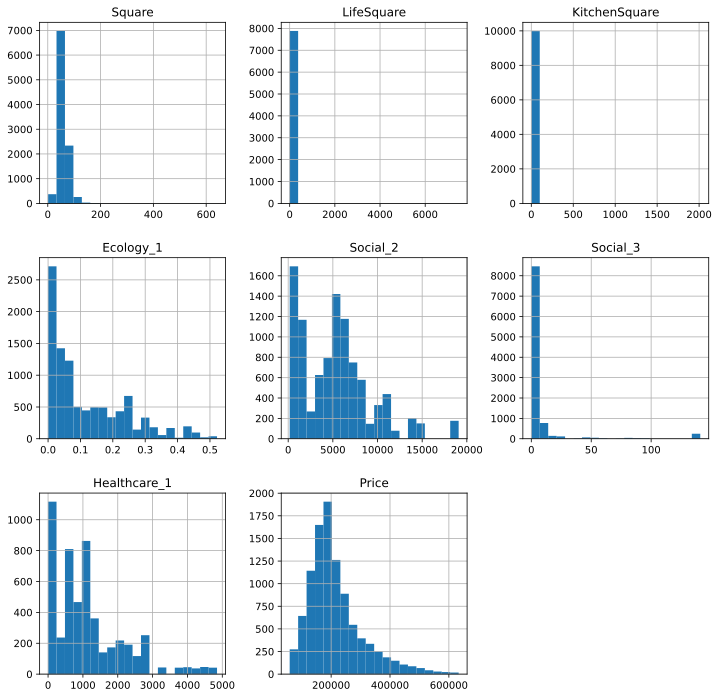

In [11]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
train_df_num_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

## с. Анализ номинальных переменных

_Также анализируем распределение номинальных признаков._

In [12]:
train_df_cat_features = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'category'])
for col in train_df_cat_features:
        un_n = train_df[col].nunique()
        uniqset = np.array(train_df[col].unique())
        print(f'no of unique {col}: {un_n}')
        print(f'{np.sort(uniqset)} \n')

no of unique Id: 10000
[    0     2     5 ... 16796 16797 16798] 

no of unique District: 205
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 199
 200 201 202 205 207 208 209] 

no of unique Rooms: 9
[ 0  1  2  3  4  5  6 10 19] 

no of unique Floor

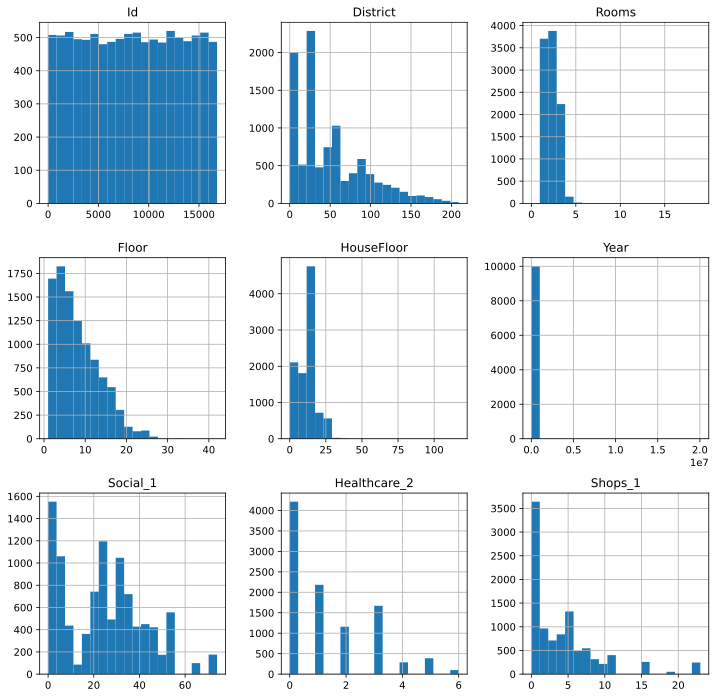

In [13]:
train_df_cat_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

## d. Поиск аномалий

_Коррекия выбросов проводилась по boxplot, так как лучше визуализируется выбросы, однако оценивались более взвешено, учитывая реальную возможность выхода наблюдения за усы, о чем модельке тоже нужно знать для более качественного прогноза. Например, квартиры площадью 100-200 м2 достаточно нормальное явление._

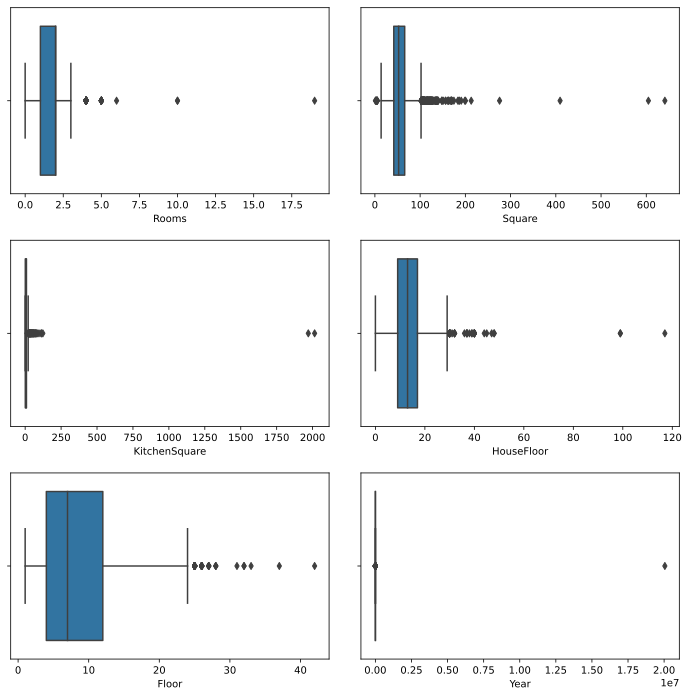

In [14]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, 
                         sharey = True,
                         figsize=(12, 12)
                        )

feature_names = train_df[['Rooms', 'Square', 'KitchenSquare', 'HouseFloor', 'Floor', 'Year']].columns.tolist()

for feature, ax in zip(feature_names, axes.flatten()):
    ax.plot(ax=axes, label=feature)
    sns.boxplot(x=feature, data=train_df, ax=ax)

fig.subplots_adjust(hspace=0.25, wspace=0.1)

# 7. Обработка выбросов

In [15]:
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

_Определение мод и медиан делается именно на тренировочном сете, потом эти значения используются как в тренировочном, так и в тестовом наборах данных. Также на основании данных трейна рассчитывается медианное значение стоимости квадратного метра недвижимости в зависимтости от дистрикта, которое затем будет использоваться в обоих датасетах по соответствию с районом._

_Cоздаю копию train_df чтобы показать алгоритм коррекции пропусков в LifeSquare_

In [16]:
df = train_df.copy() 

_Вывожу сумму пропусков по признакам. Два признака имеют пропуски. Учитывая очень большое количество пропусков в Healthcare_1, его было решено удалить. Пропущенные значения Square восстанавливались по схеме, представленной ниже._

In [17]:
df.isna().sum()

Id                  0
District            0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
Year                0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

_Генерирую новый признак LifeSquare_fraction, основанный на предположении, что LifeSquare больше всего зависит от Square и KitchenSquare. Да, существует также и влияние балкона или санузла на общую площадь, но мною было принято решение принять именно такой подход._ 

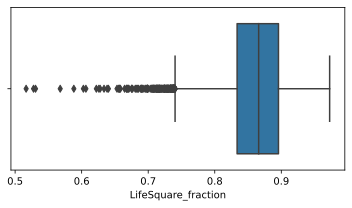

In [18]:
df['LifeSquare_fraction'] = 1 - df['KitchenSquare'] / df['Square']

plt.figure(figsize=(6, 3))
sns.boxplot(df['LifeSquare_fraction'], whis=1.5)
plt.xlabel('LifeSquare_fraction')
plt.show()

_Предполагаю также, что вклад жилой площади в общую должен быть больше 0.7, поэтому значения меньше этого заменил медианой._

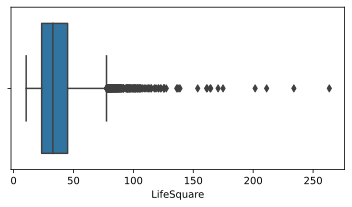

In [19]:
df.loc[df['LifeSquare_fraction'] < 0.7, 'LifeSquare_fraction'] = df['LifeSquare_fraction'].median()

plt.figure(figsize=(6, 3))
sns.boxplot(df['LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')
plt.show()

_Генерирую новый признак LifeSquare_new чисто математичсеки на основании Square, в котром не было пропусков. Рисую график взаимного распределения LifeSquare_new и LifeSquare, на котором видно, что часть данных в LifeSquare представлена медианным значением, которое с моей точки зрения было бы лучше заменить LifeSquare_new. Пропуски в LifeSquare также меняем на значения из LifeSquare_new._

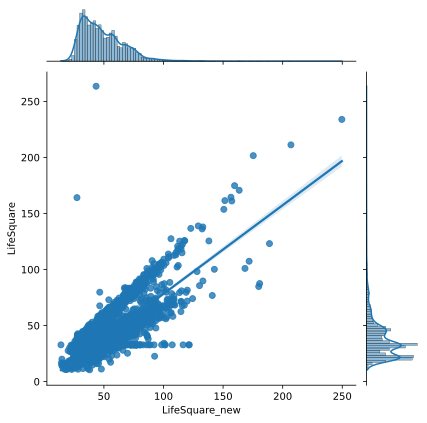

In [20]:
df['LifeSquare_new'] = df['LifeSquare_fraction'] * df['Square']

grid = sns.jointplot(df['LifeSquare_new'], df['LifeSquare'], kind='reg')
plt.show()

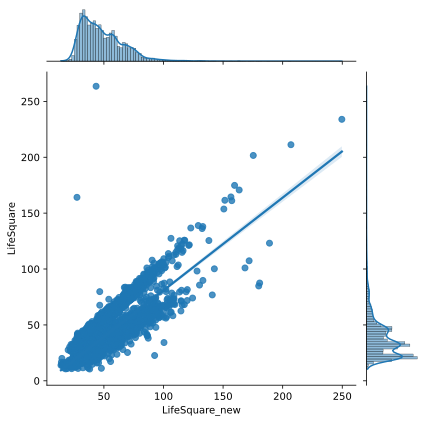

In [21]:
df.loc[df['LifeSquare'] == df['LifeSquare'].median(), 'LifeSquare'] = df['LifeSquare_new']

grid = sns.jointplot(df['LifeSquare_new'], df['LifeSquare'], kind='reg')
plt.show()

In [22]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['LifeSquare_new']

df.drop(['LifeSquare_new', 'LifeSquare_fraction', 'Healthcare_1'], inplace=True, axis=1)

_Убеждаемся в отсутсвии пропусков после коррекции_

In [23]:
df.isna().sum()

Id               0
District         0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
Year             0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_2     0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

_Визуально оцениваю влияние LifeSquare на целевую переменную._

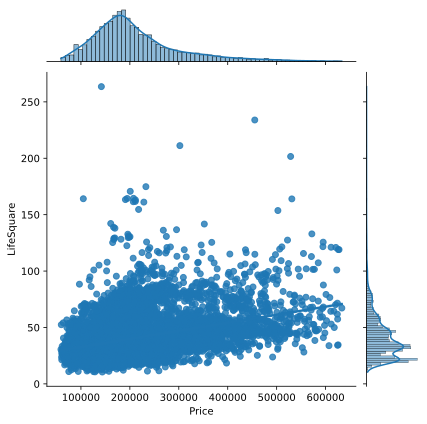

In [24]:
grid = sns.jointplot(df['Price'], df['LifeSquare'], kind='reg')
plt.show()

_Также для анализа были сгенериррован ряд новых признаков:
"Floor_altitude" - представляет собой отношение этажа, на котором расположена недвидимость к общему числу этажей в доме.
"IsFirstFloor" - номинальный признак, основанный на том, что большинству людей квартры на первом этаже кажутся менее привлекательными.
"Median_Price_per_square" - описывался ранее, высчитывается на трейне, имее большое значение, так как район действительно много значит. В тестовом датасете был ряд районов, которых не было в трейне, значения Median_Price_per_square в таких случаях заполнлись медианой.
"Year_expensive" - на основании разной стоимости было выделено 10 промежутков времени строительства домов 
Дополнительно проведена операция перевода ряда признаков в дамми-переменные._

In [25]:
df['Price_per_square'] = df["Price"] / df['Square'].round(decimals=3)
df_mean_price_dist = df.groupby('District').median()['Price_per_square'].round()
df_mean = pd.DataFrame(df_mean_price_dist)
df_mean.rename(columns = {'Price_per_square' : 'Median_Price_per_square'}, inplace = True)
df = df.merge(df_mean, on=['District'])

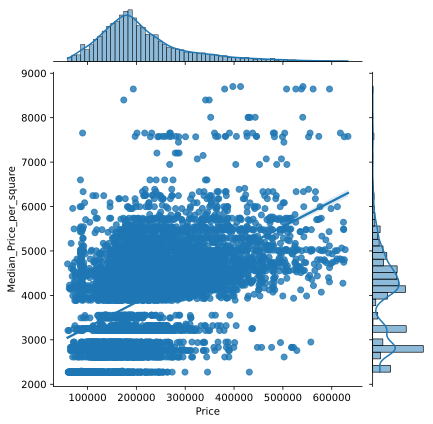

In [26]:
grid = sns.jointplot(df['Price'], df['Median_Price_per_square'], kind='reg')
plt.show()

In [27]:
df['Year_expensive'] = 0
df.loc[df['Year'] <= 1955, 'Year_expensive'] = 10
df.loc[(df['Year'] > 1995) & (df['Year'] <= 2005), 'Year_expensive'] = 9
df.loc[(df['Year'] > 1985) & (df['Year'] <= 1995), 'Year_expensive'] = 8
df.loc[(df['Year'] > 1977) & (df['Year'] <= 1985), 'Year_expensive'] = 7
df.loc[df['Year'] == 1976, 'Year_expensive'] = 7
df.loc[(df['Year'] > 1955) & (df['Year'] <= 1965), 'Year_expensive'] = 6
df.loc[(df['Year'] > 2005) & (df['Year'] <= 2015), 'Year_expensive'] = 5
df.loc[(df['Year'] > 1970) & (df['Year'] <= 1975), 'Year_expensive'] = 4
df.loc[df['Year'] > 2015, 'Year_expensive'] = 3
df.loc[(df['Year'] > 1965) & (df['Year'] <= 1970), 'Year_expensive'] = 2
df.loc[df['Year'] == 1977, 'Year_expensive'] = 1

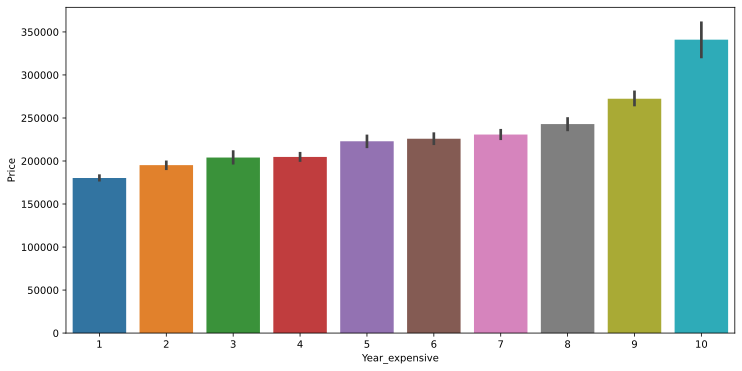

In [28]:
plt.figure(figsize = (12, 6))
sns.barplot(x='Year_expensive', y='Price', data=df)
plt.show()

In [29]:
del df

# 8. Обработка пропусков  и генерация новых признаков

In [30]:
train_df = preprocessor.new_features(train_df)
test_df = preprocessor.new_features(test_df)

# Промежуточные выводы №1

###### Обработаны пропуски в столбце LifeSquare.
    
###### Обработаны сомнительные недостоверные данные в столбцах:
    Rooms - обработаны слишком маленькие и неправдоподобно большие значения
    KitchenSquare - обработаны слишком маленькие и неправдоподобно большие значения
    LifeSquare - обработаны слишком маленькие и неправдоподобно большие значения
    HouseFloor - обработаны слишком маленькие и неправдоподобно большие значения
    Floor - обработаны слишком маленькие и неправдоподобно большие значения
    Year - удалены значения больше 2020.
   
###### Подготовлены признаки для обучения модели:
    Сгенерированы Floor_altitude, IsFirstFloor, Median_Price_per_square, Year_expensive
    Переведены категориальные признаки в дамми-переменные

# 9. Разделение тренировочного датасета на собственно тренировочный и валидационный

In [31]:
X = train_df.drop(columns='Price')
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

# 10. Тренировка финальной модели

_Среди всех использованных моделей лучшую метрику показал RandomForestRegressor, поэтому использовался именно он с гиперпараметрами, определенными с помощью GridSearch. Плюс я все таки сам уменьшил глубину, боясь переобучения._

In [32]:
final_model = RandomForestRegressor(criterion='mse',
                                    max_depth=9,
                                    min_samples_leaf=6,
                                    random_state=42, 
                                    n_estimators=160
                                   )

final_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=9, min_samples_leaf=6,
                      n_estimators=160, random_state=42)

# 11. Валидация

Train R2:	0.844
Test R2:	0.735


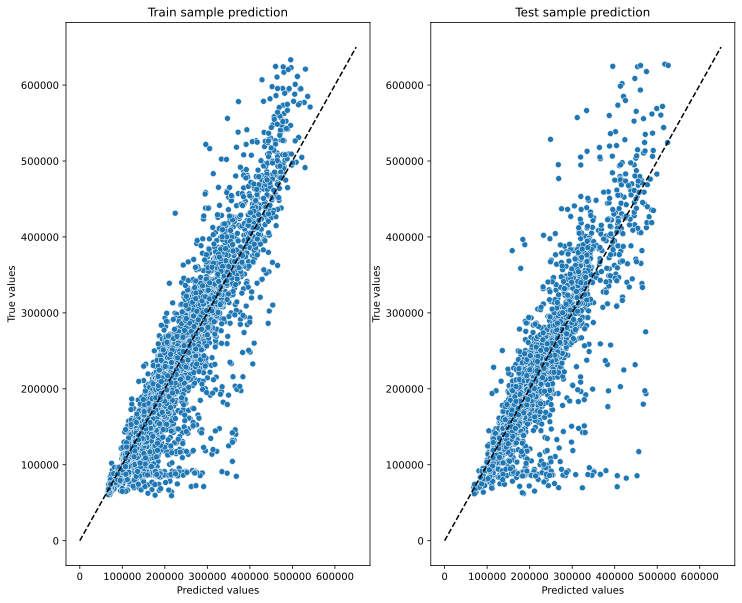

In [33]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [34]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head()

feature_name  importance
3                    Square    0.468963
19  Median_Price_per_square    0.392922
2                     Rooms    0.029502
4                LifeSquare    0.014450
20           Year_expensive    0.012162

_Распределение значимости признаков соответствует моим ожиданиям: больший вклад вносит площадь недвидимости и разные ее компоненты, количество комнат определенно коррелирует с этими показателями. Интересено, что год постройки дома также всетаки вносит достойный вклад._

# Промежуточные выводы №2

###### Обучены несколько моделей, выбрана показавшая лучшую метрику r2 - RandomForestRegressor.
###### Проанализировано качество работы модели на трейне и валидационном датасете.
###### Оценено, какие признаки оказывают наибольшее влияние на модель.

# 12. Загрузка submission и предсказание стоимости недвижимости

In [35]:
submit = pd.read_csv('./sample_submission.csv', sep=',')
predictions = final_model.predict(test_df)
submit['Price'] = predictions
submit.set_index('Id', inplace=True)
submit.to_csv('AErmak_predictions.csv')

In [36]:
submit.head(3)

Price
Id                 
4567  163467.767225
5925  117862.137797
960   154237.951895